Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Predicted Internet Users (per 100 people):
 [88.34375    30.20271111  4.61889286 64.46551508 44.02850317 45.08888925
 65.02560952 88.12705    47.55725806 61.74004365 47.40648602 47.55725806
 42.59422619 23.64257738 22.39992143 96.57415476 79.67316786 64.25401984
 78.76695595 69.31470357 91.04114762 39.46734524 41.64676667 59.99461746
 47.55725806 22.1929619  57.61657024 16.09329762 70.09630595 53.99787143
 19.32489405 81.62475873 39.64455952 39.08676667 84.98162222 79.36123452
 54.59458571 51.92390952 88.43576667 93.39134048 93.4585619  54.26891429
 25.93546548 64.87245476 30.51121111 79.23037024 54.21772381 42.84657677
 96.43415476 40.54505238  9.89182183 15.17712976 72.97755238]

Mean Squared Error: 0.20730738814749602
R-squared: 0.999663751684939

CPU Time 43.790101051330566 



<Figure size 2000x1000 with 0 Axes>

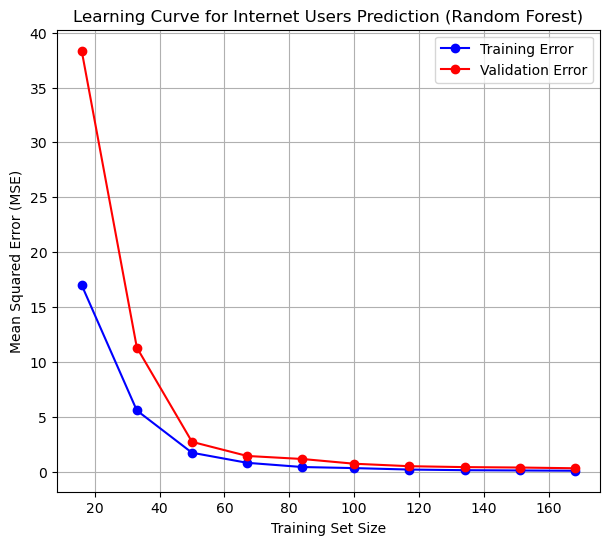

In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, r2_score, f1_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import time

# Read the CSV file
worldBankData = pd.read_csv('World Bank Data.csv', encoding='ISO-8859-1')

# Remove commas from the entire DataFrame (this will remove commas from all cells, including non-numeric ones)
worldBankData = worldBankData.replace(",", "", regex=True)

# Convert the entire DataFrame to numeric (invalid parsing will be coerced to NaN)
worldBankData = worldBankData.apply(pd.to_numeric, errors='coerce')

# Fill missing values with the mean of each column
numericalColumns = worldBankData.select_dtypes(include=['float64', 'int64'])
for col in numericalColumns:
    worldBankData[col].fillna(worldBankData[col].mean(), inplace=True)

# Define the non-numerical columns to drop
non_numerical_columns = ['Country Name', 'Region Code', 'Country Code', 'Population CGR 1960-2015', 'Popltn Largest City % of Urban Pop']

# Define the columns to drop, including the target variable
columns_to_drop = ['GDP, PPP (current international $)', 'Exports of goods and services (% of GDP)'] + non_numerical_columns

# Drop the unnecessary columns
x = worldBankData.drop(columns=columns_to_drop)

# Set the target variable to "Internet users (per 100 people)"
y = worldBankData['Internet users (per 100 people)']

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

start_time = time.time()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestRegressor and GridSearchCV
dataModel = RandomForestRegressor()
grid_search = GridSearchCV(estimator=dataModel, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit the model using the training data
grid_search.fit(x_train, y_train)

end_time = time.time()
cpu_time = end_time - start_time

# Get the best model from GridSearchCV
print(f"Best Parameters: {grid_search.best_params_}\n")
dataModel = grid_search.best_estimator_

# Make predictions using the test set
yPrediction = dataModel.predict(x_test)
print("Predicted Internet Users (per 100 people):\n", yPrediction)

# Calculate and print the evaluation metrics
mse = mean_squared_error(y_test, yPrediction)
r2 = r2_score(y_test, yPrediction)
print(f"\nMean Squared Error: {mse}")
print(f"R-squared: {r2}\n")
print("CPU Time",cpu_time,"\n")

# Feature importance
feature_importances = dataModel.feature_importances_

# Pair feature names with their importance scores
features = x.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort by importance and print the importance table
importance_df = importance_df.sort_values(by='Importance', ascending=False)
#print(importance_df)

# Plotting the decision tree
plt.figure(figsize=(20, 10))
#plot_tree(dataModel.estimators_[0], filled=True, feature_names=x.columns, class_names=['Target'])
#plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    dataModel, x_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Convert negative MSE values to positive
train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

# Step 5: Plot the learning curve
plt.figure(figsize=(7, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Error", color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label="Validation Error", color='red', marker='o')
plt.title('Learning Curve for Internet Users Prediction (Random Forest)')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)

plt.savefig("learningcurve.jpg", format='jpg')
plt.show()
